# Train and Optimize

Train a neural network on TCGA+GTEX gene expression to classify tissue/disease

In [3]:
import sys
import os
import json
import pandas as pd
import numpy as np
import tensorflow as tf

# fix random seed for reproducibility
np.random.seed(42)

os.chdir(os.path.expanduser("~/data/pancan-gtex"))

## Load and Wrangle Data

In [4]:
X = pd.read_hdf(os.path.expanduser("pancan-gtex-pruned.h5"), "samples")
Y = pd.read_hdf(os.path.expanduser("pancan-gtex-pruned.h5"), "labels")
print("Loaded {} samples with {} features and {} labels".format(X.shape[0], X.shape[1], Y.shape[1]))

Loaded 17277 samples with 5540 features and 40 labels


In [6]:
# Create a multi-label one-hot for tumor/normal and primary site
from sklearn.preprocessing import LabelEncoder

primary_site_encoder = LabelEncoder()
Y["primary_site_value"] = pd.Series(
    primary_site_encoder.fit_transform(Y["_primary_site"]), index=Y.index, dtype='int32')

tumor_normal_encoder = LabelEncoder()
Y["tumor_normal_value"] = pd.Series(
    tumor_normal_encoder.fit_transform(Y["tumor_normal"]), index=Y.index, dtype='int32')

Y_onehot = np.append(
    Y["tumor_normal_value"].values.reshape(Y.shape[0],-1), 
    tf.keras.utils.to_categorical(Y["primary_site_value"]), axis=1)

In [8]:
# Split into training and test sets strattified on primary site
from sklearn.model_selection import StratifiedShuffleSplit
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_index, test_index in split.split(X.values, Y.primary_site_value):
    X_train = X.values[train_index]
    X_test = X.values[test_index]
    Y_train = Y.iloc[train_index]
    Y_test = Y.iloc[test_index]
    Y_onehot_train = Y_onehot[train_index]
    Y_onehot_test = Y_onehot[test_index]
    
print("Train:", X_train.shape, "Test:", X_test.shape)

Train: (13821, 5540) Test: (3456, 5540)


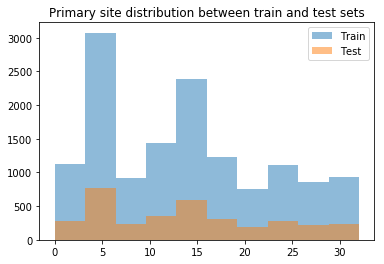

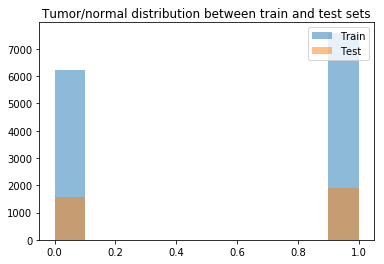

In [10]:
import matplotlib.pyplot as plt

# Lets see how big each class is based on primary site
plt.hist(Y_train.primary_site_value.values, alpha=0.5, label='Train')
plt.hist(Y_test.primary_site_value.values, alpha=0.5, label='Test')
plt.legend(loc='upper right')
plt.title("Primary site distribution between train and test sets")
plt.show()

# Lets see how big each class is based tumor/normal
plt.hist(Y_train.tumor_normal_value.values, alpha=0.5, label='Train')
plt.hist(Y_test.tumor_normal_value.values, alpha=0.5, label='Test')
plt.legend(loc='upper right')
plt.title("Tumor/normal distribution between train and test sets")
plt.show()

## Build and Train Model

In [11]:
def create_model(input_shape, output_shape, params):
    inputs = tf.keras.layers.Input(shape=(input_shape,))

    x = tf.keras.layers.BatchNormalization()(inputs)

    x = tf.keras.layers.Dense(64, activation="relu")(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    
    x = tf.keras.layers.Dense(64, activation="relu")(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    
    outputs = tf.keras.layers.Dense(output_shape, activation="sigmoid")(x)
    
    model = tf.keras.models.Model(inputs=inputs, outputs=outputs)
    model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["acc"])
    return model

model = create_model(X_train.shape[1], Y_onehot_train.shape[1], {})
model.summary()

callbacks = [tf.keras.callbacks.EarlyStopping(monitor="acc", min_delta=0.05, patience=2, verbose=2, mode="max")]
model.fit(X_train, Y_onehot_train, epochs=10, batch_size=128, shuffle="batch", callbacks=callbacks)
print(model.metrics_names, model.evaluate(X_test, Y_onehot_test))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 5540)              0         
_________________________________________________________________
batch_normalization (BatchNo (None, 5540)              22160     
_________________________________________________________________
dense (Dense)                (None, 64)                354624    
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 34)                2210      
Total para

In [22]:
# Save the model to disk so we can load, evaluate, infer and explain independantly
with open("pruned-params.json", "w") as f:
    f.write(json.dumps({
        "tumor_normal": tumor_normal_encoder.classes_.tolist(),
        "primary_site": primary_site_encoder.classes_.tolist(),
        "train_indices": train_index.tolist(),
        "test_indices": test_index.tolist()}))
    
model.save("pruned-model.h5")

In [23]:
# Copy to S3/PRP for training as well as public_html for faster access in colab infer
!aws --profile {os.getenv("AWS_PROFILE")} --endpoint {os.getenv("AWS_S3_ENDPOINT")} \
    s3 cp pruned-params.json s3://stuartlab/pancan-gtex/ --acl public-read

!aws --profile {os.getenv("AWS_PROFILE")} --endpoint {os.getenv("AWS_S3_ENDPOINT")} \
    s3 cp pruned-model.h5 s3://stuartlab/pancan-gtex/ --acl public-read

upload: ./pruned-params.json to s3://stuartlab/pancan-gtex/pruned-params.json
upload: ./pruned-model.h5 to s3://stuartlab/pancan-gtex/pruned-model.h5
